In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
train_df = pd.read_csv("../data/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("../data/test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [5]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [7]:
temp_data = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

In [8]:
temp_data = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="category_name", how="left")

In [10]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

### Baseline Model:

Now let us build a baseline model using the given features and newly created features.

In the following block, we will do :
- Create a new feature for week day
- Label encode the cateforical variables
- Drop the columns that are not needed in the model.

In [11]:
# Target and ID variables #
train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_df.drop(cols_to_drop + ["region_en", "parent_category_name_en", "category_name_en", "price_new", "deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [12]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result


In [13]:
# Splitting the data for model training#
dev_X = train_X.iloc[:-200000,:]
val_X = train_X.iloc[-200000:,:]
dev_y = train_y[:-200000]
val_y = train_y[-200000:]
print(dev_X.shape, val_X.shape, test_X.shape)

# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

(1303424, 12) (200000, 12) (508438, 12)
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.236273
[40]	valid_0's rmse: 0.233508
[60]	valid_0's rmse: 0.232199
[80]	valid_0's rmse: 0.231535
[100]	valid_0's rmse: 0.231099
[120]	valid_0's rmse: 0.2307
[140]	valid_0's rmse: 0.230377
[160]	valid_0's rmse: 0.230111
[180]	valid_0's rmse: 0.229921
[200]	valid_0's rmse: 0.229706
[220]	valid_0's rmse: 0.229517
[240]	valid_0's rmse: 0.229369
[260]	valid_0's rmse: 0.229227
[280]	valid_0's rmse: 0.229101
[300]	valid_0's rmse: 0.228988
[320]	valid_0's rmse: 0.2289
[340]	valid_0's rmse: 0.228828
[360]	valid_0's rmse: 0.228747
[380]	valid_0's rmse: 0.228664
[400]	valid_0's rmse: 0.228605
[420]	valid_0's rmse: 0.228531
[440]	valid_0's rmse: 0.228459
[460]	valid_0's rmse: 0.228373
[480]	valid_0's rmse: 0.228285
[500]	valid_0's rmse: 0.228219
[520]	valid_0's rmse: 0.22817
[540]	valid_0's rmse: 0.228123
[560]	valid_0's rmse: 0.228088
[580]	valid_0's rmse: 0.228034
[600]	v

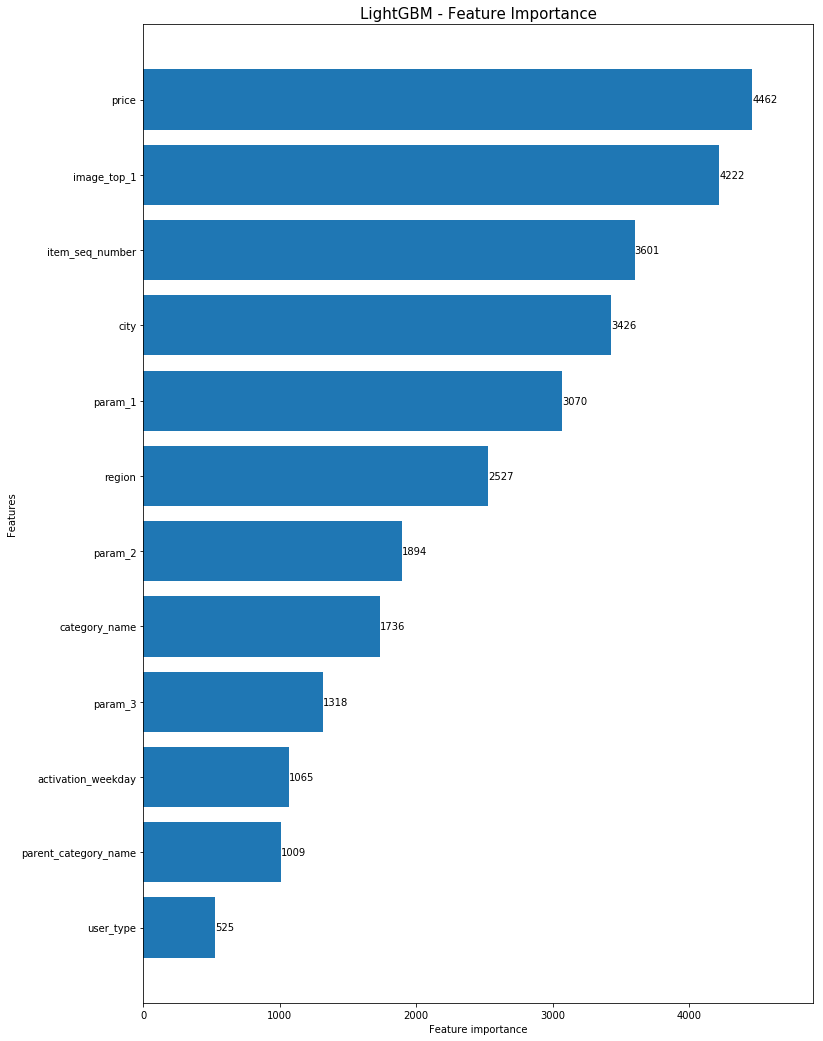

In [14]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## 0.229